# Fitting single flow curve

List of usefull scripts

The only objects that cells should share are functions and the general import in the first few cells

In [29]:
%matplotlib inline
import sys
sys.path.append("./../../")
import rheofit
import lmfit
import pybroom as pb
import matplotlib.pyplot as plt
import pandas as pd
import emcee
import corner

In [30]:
pd.set_option('display.notebook_repr_html', True)

def _repr_latex_(self):
    return "\centering{%s}" % self.to_latex()

pd.DataFrame._repr_latex_ = _repr_latex_  # monkey patch pandas DataFrame

## Getting Example flow curve data

In [31]:
#using provided example data
example_data=rheofit.rheodata.example_emulsion()
example_data

,Shear rate,Stress
0,999.894750,131.224750
1,891.251000,121.572250
2,794.328250,112.565250
3,707.946000,104.258000
4,630.957500,96.582950
...,...,...
96,0.015848,3.098968
97,0.014126,3.046845
98,0.012588,2.997400
99,0.011219,2.950915


## Plotting flow curve data

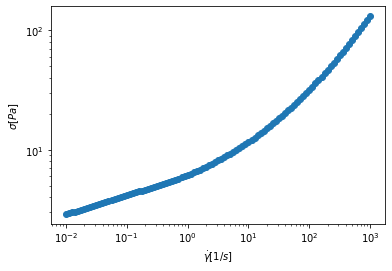

In [32]:
data=rheofit.rheodata.example_emulsion()

def plot_data(data):
    plt.plot(data['Shear rate'],data['Stress'],'o')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('$\sigma [Pa]$');
    plt.xlabel('$\dot\gamma [1/s]$');
    
    return plt.gcf()

plot_data(data);

## Fitting flow curve data to a rheological model

In [33]:
data=rheofit.rheodata.example_emulsion()
model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))
res_fit

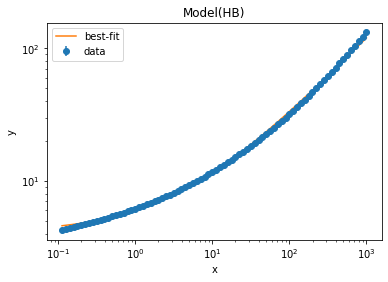

In [34]:
data=rheofit.rheodata.example_emulsion()
data=data[data['Shear rate']>0.1]
model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))

kwarg={'xscale':'log','yscale':('log')}
res_fit.plot_fit(ax_kws=kwarg,yerr=False);

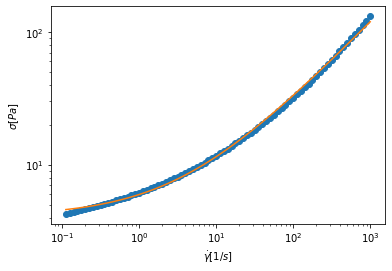

In [35]:
data=rheofit.rheodata.example_emulsion()
data=data[data['Shear rate']>0.1]

model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))

def plot_fit(res_fit, xlist=None):
    if xlist is None:
        xlist=res_fit.userkws['x']
    
    plt.plot(res_fit.userkws['x'], res_fit.data,'o',label='Data')
    plt.plot(xlist, res_fit.eval(x=xlist),label='Best fit')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('$\sigma [Pa]$')
    plt.xlabel('$\dot\gamma [1/s]$')

plot_fit(res_fit);

## Explore fit results with pybroom 

In [36]:
data=rheofit.rheodata.example_emulsion()
model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))

pb.glance(res_fit)

,model,method,num_params,num_data_points,chisqr,redchi,AIC,BIC,num_func_eval,success,message
0,Model(HB),leastsq,3,101,0.523638,0.005343,-525.469582,-517.624221,29,True,Fit succeeded.


In [37]:
data=rheofit.rheodata.example_emulsion()
model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))

pb.tidy(res_fit)

,name,value,min,max,vary,expr,stderr,init_value
0,K,2.562815,0,inf,True,NaN,0.091189,1.0
1,n,0.539288,0,1.0,True,NaN,0.007523,0.5
2,ystress,3.186295,0,inf,True,NaN,0.062969,1.0


In [38]:
data=rheofit.rheodata.example_emulsion()
model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))

augmented=pb.augment(res_fit)
augmented

,x,data,best_fit,residual
0,999.894750,131.224750,109.492113,-0.165614
1,891.251000,121.572250,103.098212,-0.151959
2,794.328250,112.565250,97.083545,-0.137535
3,707.946000,104.258000,91.430975,-0.123032
4,630.957500,96.582950,86.118672,-0.108345
...,...,...,...,...
96,0.015848,3.098968,3.460439,0.116642
97,0.014126,3.046845,3.443949,0.130333
98,0.012588,2.997400,3.428427,0.143800
99,0.011219,2.950915,3.413850,0.156878


## Plot residuals

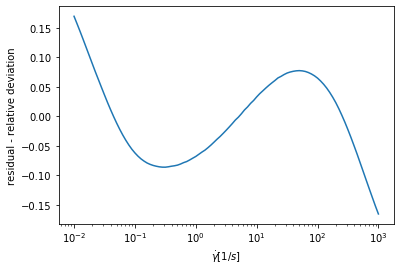

In [39]:
data=rheofit.rheodata.example_emulsion()
model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))


def plot_residuals(res_fit):
    augmented=pb.augment(res_fit)
    plt.plot('x','residual',data=augmented)
    plt.xscale('log')
    plt.ylabel('residual - relative deviation');
    plt.xlabel('$\dot\gamma [1/s]$');
    
    return plt.gcf()

plot_residuals(res_fit);

## Confidence interval

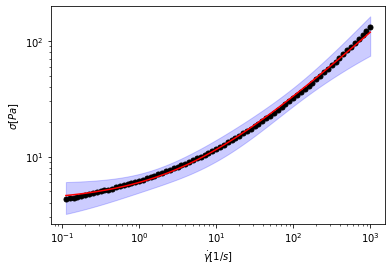

In [40]:
data=rheofit.rheodata.example_emulsion()
data=data[data['Shear rate']>0.1]
model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))

def plot_confidence(res_fit,expand=10):
    dely = res_fit.eval_uncertainty(x=res_fit.userkws['x'],sigma=3)*expand
    
    plt.plot(res_fit.userkws['x'], res_fit.data,'o',color='black',label='Data',markersize=5)
    plt.plot(res_fit.userkws['x'], res_fit.best_fit,label='Best fit TC model',color='red')
    plt.fill_between(res_fit.userkws['x'], res_fit.best_fit-dely,res_fit.best_fit+dely,
                     color='blue',alpha=0.2,label='0.9973 Confidence interval')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('$\sigma [Pa]$')
    plt.xlabel('$\dot\gamma [1/s]$')
    
    return plt.gcf()

plot_confidence(res_fit);

## Fit specific shear rate range

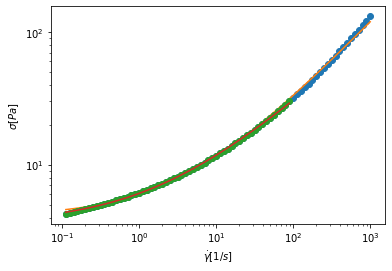

In [41]:
data=rheofit.rheodata.example_emulsion()
data=data[data['Shear rate']>0.1]
model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))

min_shear_rate=0.1
max_shear_rate=1000

def fit_range(res_fit,min_shear_rate=0.1,max_shear_rate=100):
    data=pd.DataFrame.from_dict({'Shear rate':res_fit.userkws['x'],'Stress':res_fit.data})
    mask=(data['Shear rate']>=min_shear_rate) & (data['Shear rate']<=max_shear_rate)
    res_fit=model.fit(data[mask]['Stress'],x=data[mask]['Shear rate'],weights=1/(data[mask]['Stress']))
    
    return res_fit

plot_fit(res_fit);
plot_fit(fit_range(res_fit));

In [42]:
data=rheofit.rheodata.example_emulsion()
model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))

min_shear_rate=0.1
max_shear_rate=1000

def fit_range(res_fit,min_shear_rate=0.1,max_shear_rate=100):
    data=pd.DataFrame.from_dict({'Shear rate':res_fit.userkws['x'],'Stress':res_fit.data})
    mask=(data['Shear rate']>min_shear_rate) & (data['Shear rate']<max_shear_rate)
    res_fit=model.fit(data[mask]['Stress'],x=data[mask]['Shear rate'],weights=1/(data[mask]['Stress']))
    
    return res_fit

display(pb.tidy(fit_range(res_fit,min_shear_rate=0.1,max_shear_rate=10)))
display(pb.tidy(fit_range(res_fit,min_shear_rate=0.1,max_shear_rate=100)))
display(pb.tidy(fit_range(res_fit,min_shear_rate=0.1,max_shear_rate=1000)))

,name,value,min,max,vary,expr,stderr,init_value
0,K,2.946032,0,inf,True,NaN,0.033507,1.0
1,n,0.452852,0,1.0,True,NaN,0.004298,0.5
2,ystress,3.219395,0,inf,True,NaN,0.028909,1.0


,name,value,min,max,vary,expr,stderr,init_value
0,K,2.498040,0,inf,True,NaN,0.037762,1.0
1,n,0.517414,0,1.0,True,NaN,0.003954,0.5
2,ystress,3.589250,0,inf,True,NaN,0.034026,1.0


,name,value,min,max,vary,expr,stderr,init_value
0,K,1.880492,0,inf,True,NaN,0.051488,1.0
1,n,0.595807,0,1.0,True,NaN,0.005270,0.5
2,ystress,4.088222,0,inf,True,NaN,0.059816,1.0


## Reduced $\chi^2$ sensitivity on shear rate range

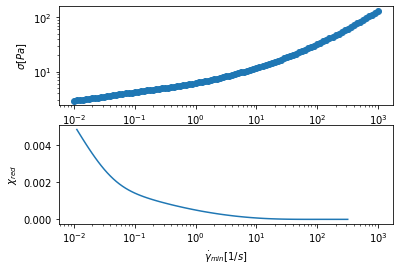

In [43]:
data=rheofit.rheodata.example_emulsion()
model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))


def explore_redchi(res_fit,min_shear_rate=0.01,max_shear_rate=1000):
    data=pd.DataFrame.from_dict({'Shear rate':res_fit.userkws['x'],'Stress':res_fit.data})
    res_dict={min_shear:fit_range(res_fit,min_shear_rate=min_shear,max_shear_rate=1000) 
              for min_shear in data['Shear rate'][10:-1]}
    
    ax1= plt.subplot(2,1,1)
    
    plt.plot(data['Shear rate'],data['Stress'],'o')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$\dot\gamma [1/s]$')
    plt.ylabel('$\sigma [Pa]$')

    ax2= plt.subplot(2,1,2,sharex = ax1)
    
    plt.plot(list(res_dict.keys()),pb.glance(res_dict)['redchi'])
    plt.xscale('log')
    plt.ylabel('$\chi_{red}$')
    plt.xlabel('$\dot\gamma_{min} [1/s]$')
    
    return plt.gcf()
    
explore_redchi(res_fit);

## Model parameter sensitivity on shear rate range

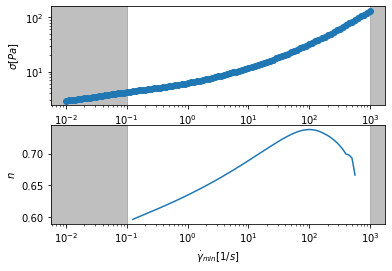

In [44]:
data=rheofit.rheodata.example_emulsion()
data.sort_values('Shear rate',ascending=False, inplace=True)

model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))


def explore_param_keephigh(res_fit,min_shear_rate=0.01,max_shear_rate=1000,param_name=None):
    '''keep the right range of data for the fit
    answer the question: how important it is how low we extend the analysis at low shear?
    '''
    data=pd.DataFrame.from_dict({'Shear rate':res_fit.userkws['x'],'Stress':res_fit.data})
    data.sort_values('Shear rate',ascending=False, inplace=True)
    res_fit=res_fit.model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))
    res_fit=fit_range(res_fit,min_shear_rate=min_shear_rate,max_shear_rate=max_shear_rate)
    res_dict={min_shear:fit_range(res_fit,min_shear_rate=min_shear,max_shear_rate=max(res_fit.userkws['x'])) 
              for min_shear in res_fit.userkws['x'][5:-1]}
    
    ax1= plt.subplot(2,1,1)
    
    plt.plot(data['Shear rate'],data['Stress'],'o')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$\dot\gamma [1/s]$')
    plt.ylabel('$\sigma [Pa]$')
    
    xlim=plt.gca().get_xlim()
    plt.axvspan(xlim[0],min_shear_rate,color='gray',alpha=0.5)
    plt.axvspan(max_shear_rate,xlim[1],color='gray',alpha=0.5)
    
    ax2= plt.subplot(2,1,2,sharex = ax1)
    
    plt.plot(list(res_dict.keys()),pb.tidy(res_dict)['value'][pb.tidy(res_dict)['name']=='n'])
    plt.xscale('log')
    plt.ylabel('$'+param_name+'$')
    plt.xlabel('$\dot\gamma_{min} [1/s]$')
    
    plt.axvspan(xlim[0],min_shear_rate,color='gray',alpha=0.5)
    plt.axvspan(max_shear_rate,xlim[1],color='gray',alpha=0.5)

    plt.gca().set_xlim(xlim)
    
    return plt.gcf()
    
explore_param_keephigh(res_fit,min_shear_rate=0.1,param_name='n');

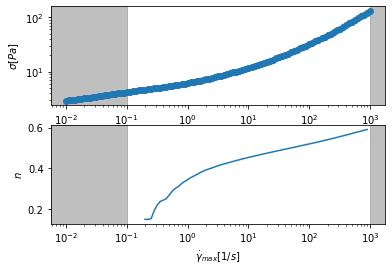

In [45]:
data=rheofit.rheodata.example_emulsion()
data.sort_values('Shear rate',ascending=False, inplace=True)

model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))


def explore_param_keeplow(res_fit,min_shear_rate=0.01,max_shear_rate=1001,param_name=None):
    '''keep the right range of data for the fit
    answer the question: how important it is how low we extend the analysis at low shear?
    '''
    
    data=pd.DataFrame.from_dict({'Shear rate':res_fit.userkws['x'],'Stress':res_fit.data})
    data.sort_values('Shear rate',ascending=True, inplace=True)
    res_fit=res_fit.model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))
    res_fit=fit_range(res_fit,min_shear_rate=min_shear_rate,max_shear_rate=max_shear_rate)
    res_dict={max_shear:fit_range(res_fit,min_shear_rate=min(res_fit.userkws['x']),max_shear_rate=max_shear) 
              for max_shear in res_fit.userkws['x'][5:-1]}
    
    ax1= plt.subplot(2,1,1)
    
    plt.plot(data['Shear rate'],data['Stress'],'o')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$\dot\gamma [1/s]$')
    plt.ylabel('$\sigma [Pa]$')
    
    xlim=plt.gca().get_xlim()
    plt.axvspan(xlim[0],min_shear_rate,color='gray',alpha=0.5)
    plt.axvspan(max_shear_rate,xlim[1],color='gray',alpha=0.5)
    
    ax2= plt.subplot(2,1,2,sharex = ax1)
    
    plt.plot(list(res_dict.keys()),pb.tidy(res_dict)['value'][pb.tidy(res_dict)['name']=='n'])
    plt.xscale('log')
    plt.ylabel('$'+param_name+'$')
    plt.xlabel('$\dot\gamma_{max} [1/s]$')
    
    plt.axvspan(xlim[0],min_shear_rate,color='gray',alpha=0.5)
    plt.axvspan(max_shear_rate,xlim[1],color='gray',alpha=0.5)

    plt.gca().set_xlim(xlim)
    
    return plt.gcf()
    
explore_param_keeplow(res_fit,min_shear_rate=0.1,param_name='n');

## Emcee

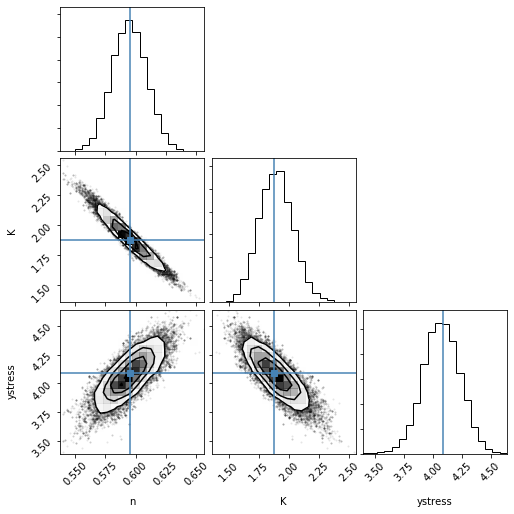

In [46]:
data=rheofit.rheodata.example_emulsion()
data=data[data['Shear rate']>0.1]
model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']*0.1))
res_emcee=res_fit.emcee(steps=1000, nwalkers=50, burn=300)

corner.corner(res_emcee.flatchain, labels=res_emcee.var_names, truths=[res_fit.params[key].value for key in res_fit.params.keys()]);
display(res_fit)